# Count Vectorizer and Ridge Regression

This is just a copy of the "Getting Started" notebook.

In [14]:
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
BASE_DIR = Path('/Users/dariog/Learning/Kaggle/real_or_not')
INPUT_DIR = BASE_DIR/'data/input'
OUTPUT_DIR = BASE_DIR/'data/output'

In [3]:
train_df = pd.read_csv(INPUT_DIR/'train.csv')
test_df = pd.read_csv(INPUT_DIR/'test.csv')

The CV score on the training set is quite different from the score on the leaderboard. It would be interesting to understand why, and if we can make them more similar. The number and positive and negative targets is not too unbalanced.

In [4]:
train_df.target.value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

Is there any association between the length of the text and the labels? This does not seem to be the case.

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  text_length  
0       1           69  
1       1           38  
2       1          133  
3       1           65  
4       1           88  


<AxesSubplot:xlabel='text_length', ylabel='target'>

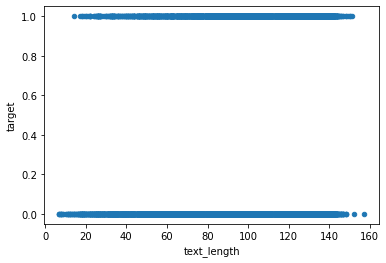

In [5]:
train_df['text_length'] = train_df['text'].str.len()
print(train_df.head())
train_df.plot('text_length', 'target', kind='scatter')

Are the entries properly shuffled? From the plot below this seems to be the case

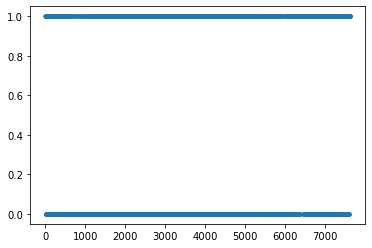

In [6]:
plt.plot(train_df.index, train_df.target, '.')

## Location

In [7]:
print(train_df.location.value_counts(normalize=True, dropna=False))

NaN                 0.332720
USA                 0.013661
New York            0.009326
United States       0.006568
London              0.005911
                      ...   
Flushing, Queens    0.000131
MIchigan            0.000131
CHICAGO             0.000131
Windsor,Ontario     0.000131
Fukuoka, Japan      0.000131
Name: location, Length: 3342, dtype: float64


In [8]:
print(test_df.location.value_counts(normalize=True, dropna=False))

NaN                        0.338645
New York                   0.011646
USA                        0.011339
Worldwide                  0.004903
United States              0.004597
                             ...   
Piscataway, NJ             0.000306
Toronto  #6ixSideMafia     0.000306
Johnstown, NY              0.000306
kyiv. ukraine              0.000306
Saint Andrews, Scotland    0.000306
Name: location, Length: 1603, dtype: float64


## Keywords

In [9]:
print(train_df.keyword.value_counts(normalize=True, dropna=False))

NaN                      0.008013
fatalities               0.005911
deluge                   0.005517
armageddon               0.005517
harm                     0.005386
                           ...   
forest%20fire            0.002496
epicentre                0.001576
threat                   0.001445
inundation               0.001314
radiation%20emergency    0.001182
Name: keyword, Length: 222, dtype: float64


In [11]:
print(test_df.keyword.value_counts(normalize=True, dropna=False))

NaN                      0.007968
deluged                  0.007049
rubble                   0.006742
demolished               0.006742
sirens                   0.006436
                           ...   
fatalities               0.001532
radiation%20emergency    0.001532
forest%20fire            0.001532
inundation               0.001226
epicentre                0.000306
Name: keyword, Length: 222, dtype: float64


## Cleaning

There is a large number of identical texts that differ only by an http or https link. These texts often have different labels. We should get rid of the contradictory ones, or go for a majority vote.

In [40]:
def remove_handle(txt):
    return re.sub('@[^ ]+', '', txt)

def remove_url(txt):
    return re.sub('https?[^ ]+', '', txt)

def remove_hashtag(txt):
    return txt.replace('#', '')

def process_txt(txt):
    txt = remove_handle(txt)
    txt = remove_url(txt)
    txt = remove_hashtag(txt)
    txt = re.sub('\s+', ' ', txt)
    txt = re.sub('^ ', '', txt)
    return txt.lower()

train_texts = train_df.text.values
contains_url = [txt for txt in train_texts if txt.find('http') != -1]
contains_handle = [txt for txt in train_texts if txt.find('@') != -1]
dirty_txt = contains_url + contains_handle

In [41]:
clean_txt = [process_txt(txt) for txt in dirty_txt]

In [42]:
clean_txt[:10]

['wholesale markets ablaze ',
 'we always try to bring the heavy. metal rt ',
 'africanbaze: breaking news:nigeria flag set ablaze in aba. ',
 'on plus side look at the sky last night it was ablaze ',
 'inec office in abia set ablaze - ',
 'barbados bridgetown jamaica \x89ûò two cars set ablaze: santa cruz \x89ûó head of the st elizabeth police superintende... ',
 'check these out: nsfw',
 'i wanted to set chicago ablaze with my preaching... but not my hotel! ',
 'i gained 3 followers in the last week. you? know your stats and grow with ',
 'how the west was burned: thousands of wildfires ablaze in california alone ']

In [43]:
clean_txt[-10:]

['lol. u got wrecked',
 'he not gonna be thinking that when he gets his shit wrecked on the first day of school ??',
 "that's beyond adorable. i hope it won't be wrecked now that it's been noticed ...",
 'see u the night wee barra to get absolutely wrecked ????',
 'did you get wrecked again?',
 "... he's gone. you can relax. i thought the wife who wrecked her cake was a goner mind lol whoops",
 'and i wrecked you both',
 'great atmosphere at the british lion gig tonight. hearing is wrecked. ',
 'rt nws issues severe thunderstorm warnings for parts of ar nc ok. expect more trauma cases: ',
 'the out of control wild fires in california even in the northern part of the state. very troubling.']

In [45]:
train_df['text'] = train_df['text'].apply(process_txt)
test_df['text'] = test_df['text'].apply(process_txt)